# Image Classification using AWS SageMaker

In this project, we will be using AWS Sagemaker to finetune a pretrained model that can perform image classification. We will have to use Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices.

In [ ]:
!pip install smdebug

In [4]:
import sagemaker

## Dataset
We will use the dog breed classication dataset to classify between different breeds of dogs in image.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [4]:
sagemaker_session = sagemaker.Session()

bucket = "mys3bucket-project"
prefix = "dogImages"
region ="us-east-1" 
role = "arn:aws:iam::450092352571:role/service-role/AmazonSageMaker-ExecutionRole-20211220T094072"

print("Default Bucket: {}".format(bucket))
print("Prefix: {}".format(prefix))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

Default Bucket: mys3bucket-project
Prefix: dogImages
AWS Region: us-east-1
RoleArn: arn:aws:iam::450092352571:role/service-role/AmazonSageMaker-ExecutionRole-20211220T094072


In [ ]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/dogImages/train/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/dogImages/test/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/dogImages/valid/

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([1, 2, 5, 7, 10]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "Testing Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Testing Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]

In [7]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [8]:
# TODO: Fit your HP Tuner
input_data = "s3://{}/dogImages".format(bucket)
tuner.fit({
'train': input_data+'/train',     
'val': input_data+'/valid',  
'test': input_data+'/test'     
}) # TODO: Remember to include your data channels

.............................................................................................................................................................................................................................................................................!


In [9]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-22 16:35:46 Starting - Preparing the instances for training
2021-12-22 16:35:46 Downloading - Downloading input data
2021-12-22 16:35:46 Training - Training image download completed. Training in progress.
2021-12-22 16:35:46 Uploading - Uploading generated training model
2021-12-22 16:35:46 Completed - Training job completed


{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '"10"',
 'epochs': '2',
 'lr': '0.0017043650242915514',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-22-16-25-20-037"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-450092352571/pytorch-training-2021-12-22-16-25-20-037/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [2]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

import sagemaker
from sagemaker.pytorch import PyTorch

In [35]:
input_data = "s3://{}/dogImages".format(bucket)
print("The input data will be {}".format(input_data))

The input data will be s3://mys3bucket-project/dogImages


In [67]:
# TODO: Create and fit an estimator
# TODO: Your estimator here
estimator = sagemaker.pytorch.estimator.PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    output_path=input_data
)

In [71]:
estimator.fit({
'train': input_data+'/train',     
'test': input_data+'/test',      
}, wait=True)

2021-12-23 19:37:22 Starting - Starting the training job...
2021-12-23 19:37:53 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2021-12-23 19:38:25 Starting - Preparing the instances for training............
2021-12-23 19:40:28 Downloading - Downloading input data.........
2021-12-23 19:41:55 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-23 19:42:08,258 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-23 19:42:08,260 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-23 19:42:08,268 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-23 19:42:14

In [72]:
pt_model_data = estimator.model_data
print("Model artifact saved at:\n", pt_model_data)

Model artifact saved at:
 s3://mys3bucket-project/dogImages/pytorch-training-2021-12-23-19-37-21-598/output/model.tar.gz


In [73]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2021-12-23-19-37-21-598
Region: us-east-1


In [39]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print("")
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))


[2021-12-23 09:47:18.971 Robeds-MacBook-Air.local:579 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-450092352571/pytorch-training-2021-12-23-14-31-35-930/debug-output
[2021-12-23 09:47:19.847 Robeds-MacBook-Air.local:579 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-23 09:47:20.907 Robeds-MacBook-Air.local:579 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias', 'gradient/ResNet_layer1.0.bn2.weight', 'gradient/ResNet_layer1.0.bn3.bias', 'gradient/ResNet_layer1.0.bn3.weight', 'gradient/ResNet_layer1.0.conv1.weight', 'gradient/ResNet_layer1.0.conv2.weight', 'gradient/ResNet_layer1.0.conv3.weight', 'gradient/ResNet_layer1.0.downsample.0.weight', 'g

In [9]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


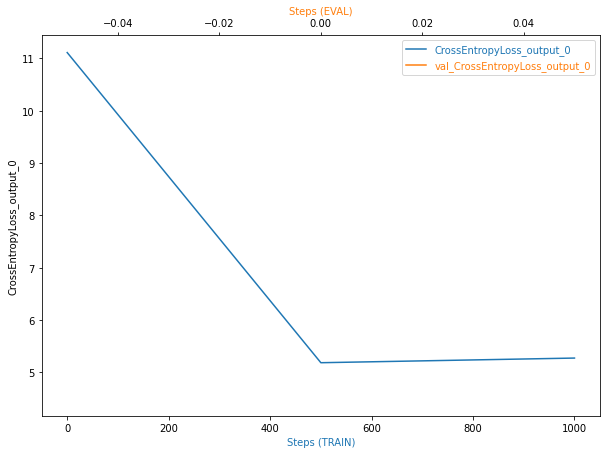

In [11]:
# TODO: Plot a debugging output.
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [13]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-450092352571/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-450092352571/pytorch-training-2021-12-22-20-34-32-547/profiler-output


Profiler data from system is available


In [14]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2021-12-22 15:54:33.808 Robeds-MacBook-Air.local:579 INFO metrics_reader_base.py:134] Getting 12 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


In [15]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-450092352571/pytorch-training-2021-12-22-20-34-32-547/rule-output


In [16]:
! aws s3 ls {rule_output_path} --recursive

2021-12-22 15:49:07     435198 pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-22 15:49:05     293781 pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-22 15:49:00        533 pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-22 15:49:00      10882 pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-22 15:49:00       2060 pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-22 15:49:00        130 pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-22 15:49:00      10790 pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-re

In [17]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-450092352571/pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-450092352571/pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-450092352571/pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-450092352571/pytorch-training-2021-12-22-20-34-32-547/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-450092352571/pytorch-traini

In [18]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [19]:
# TODO: Display the profiler output
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [40]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=34,
    destination_s3_uri=f"s3://{bucket}/data_capture",
)

In [75]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(instance_type="ml.m5.large", initial_instance_count=1) # TODO: Add your deployment configuration like instance type and number of instances

------!

In [108]:
# TODO: Run an prediction on the endpoint
# TODO: Your code to load and preprocess image to send to endpoint for prediction
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
from torchvision import transforms, models

testing_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


testset = torchvision.datasets.ImageFolder(root="./dogImages/valid/", 
            transform=testing_transform)
image = torch.utils.data.DataLoader(
            testset)
n = 0
for inputs, labels in image:
    n += 1
    print(predictor.predict(inputs))
    if n > 0:
        break

[[ 8.96296406  2.21102786 -1.6737442  -0.57857394 -3.55287266 -1.15877008
  -3.92577386 -1.55032372 -1.04422855 -0.81106097 -1.39603257  0.50386763
   1.82051075 -3.45500898 -3.34260559 -3.08033919  0.08835235  1.29066765
  -3.07962894  0.20355336  4.34512138  2.11165929 -1.76810145 -0.71448171
  -1.92364502  2.51454329 -1.64100504 -2.72048545  0.30839878  2.2488122
  -0.8485527  -1.78020251  4.83042574  0.32849091  1.93870556  3.44801664
  -2.06157851  5.82116842 -2.39217496 -2.21330667  2.81190681  2.27870417
  -0.62769449  3.1821456  -3.0534606  -1.37044513 -2.2185266  -2.14556313
   0.82702792  0.84289986  2.80582476 -2.17195988 -1.9295547  -0.31242299
   0.45493436 -0.28301886 -2.21595669 -0.73011053 -1.04217482 -0.27990893
  -1.98120558 -1.2480166  -2.01356173 -0.22596586 -2.44078302  1.26163602
  -0.45932546  3.4906466   1.38242841 -0.69670004 -0.1121272  -1.38756406
   1.96616268  4.66768456  2.43343449 -2.44523335  0.71238881  0.3268441
  -1.9188534  -2.40117097 -0.2641789   0

In [109]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()